# Diffusion 扩散模型 之 DDPM


这是 diffusion 扩散模型系列第五部分，正式介绍 diffusion model，本文是扩散模型的早期雏形。

早在2015年，Sohl-Dickstein等人发表了一篇很有趣的论文“使用非平衡热力学进行深度无监督学习”（“Deep Unsupervised Learning using Nonequilibrium Thermodynamics）”论文中写道，可以使用统计力学的摄动方法，通过反向方法可以将噪声还原成原始分布。

本部分包括以下内容：
  1. 简介
  2. 前向过程
  3. 反向过程
  4. 模型训练\
     4.1 损失函数\
     4.2 训练方法
  
笔记参考：https://github.com/acids-ircam/diffusion_models

## Denoising diffusion probabilistic models (DDPM)

In a very recent article, Ho et al. [ [ 1 ] ](#ref1) constructed over the diffusion models idea, by proposing several enhancements allowing to enhance the quality of the results. First, they proposed to rely on the following parameterization for the mean function
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

Note that now, the model is trained at outputing directly a form of _noise_ function, which is used in the sampling process. Furthermore, the authors suggest to rather use a fixed variance function

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

This leads to a new sampling procedure for the reverse process as follows (we also quickly redefine the model to output the correct dimensionality).

In [19]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

Notably, the forward process posteriors are tractable when conditioned on $\mathbf{x}_{0}$

\begin{align}
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) &= \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf {1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
\end{align}

相应的均值 $\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0})$ 和方差 $\tilde{\beta}$ 为：

\begin{align}
\tilde{\mathbf{\mu}}_{t}(\mathbf{x}_{t},\mathbf{x}_{0}) &= \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{1 - \bar{\alpha}_{t}}\mathbf{x}_{0} + \frac{\sqrt{\bar{\alpha}_{t}}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}\mathbf{x}_{t}\\
\tilde{\beta}_{t} &= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_{t}
\end{align}

## Training in DDPM

进一步改进简化方差 ，$\mathcal{L}$ 表示成 KL 散度之和：

\begin{align}
\mathcal{L} &= \mathbb{E}_{q}\left[ \mathcal{L}_{T} + \sum_{t>1} \mathcal{L}_{t-1} + \mathcal{L}_{0} \right] \\
\mathcal{L}_{T} &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p(\mathbf{x}_{T})) \\
\mathcal{L}_{t-1} &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
\mathcal{L}_{0} &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

式中的 KL 散度比较的是高斯分布，意味着其有解析解。

In [20]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

This leads to a new loss function as implemented in the following (note that this objective does not provide large change to the optimization itself).

In [21]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

### Simplifying loss to denoising score matching

The paper by Ho et al. [ [ 1 ] ](#ref1) proposes a new parameterization for the mean of the reverse process
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1 - \alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$
Based on this parametrization, they show that the training objective can simplify to
$$
\mathcal{L}_{t-1}-C=\mathbb{E}_{\mathbf{x}_{0},\mathbf{\epsilon}}\left[ \frac{\beta_{t}^{2}}{2\sigma_{t}^{2}\alpha_{t}(1-\bar{\alpha}_{t})} \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$
which resembles denoising score matching over multiple noise scales indexed by $t$.

#### Further simplified training objective

The authors discuss the fact that it is beneficial to the sample quality to completely remove the complicated factor at the beginning of the loss. This further simplifies the objective as
$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$
We can see that this objective now very closely ressemble the denoising score matching formulation. Furthermore, it provides an extremely simple implementation.

In [22]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

#### Stabilizing training with Exponential Moving Average (EMA)

This idea is found in most of the implementations, which allows to implement a form of _model momentum_. Instead of directly updating the weights of the model, we keep a copy of the previous values of the weights, and then update a weighted mean between the previous and new version of the weights. Here, we reuse the implementation proposed in the [DDIM repository](https://github.com/ermongroup/ddim).

In [23]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

训练过程定义如下：

tensor(1.1240, grad_fn=<MeanBackward0>)
tensor(0.5651, grad_fn=<MeanBackward0>)
tensor(0.4491, grad_fn=<MeanBackward0>)
tensor(0.8212, grad_fn=<MeanBackward0>)
tensor(0.9979, grad_fn=<MeanBackward0>)
tensor(0.4364, grad_fn=<MeanBackward0>)
tensor(0.6083, grad_fn=<MeanBackward0>)
tensor(0.6552, grad_fn=<MeanBackward0>)
tensor(0.7025, grad_fn=<MeanBackward0>)
tensor(1.1096, grad_fn=<MeanBackward0>)


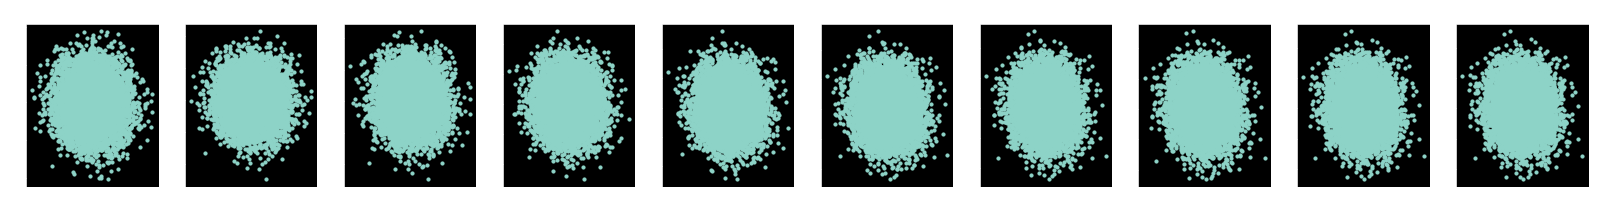

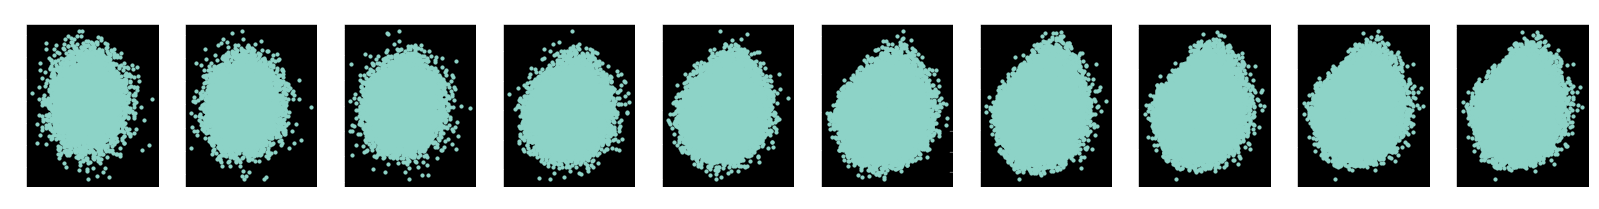

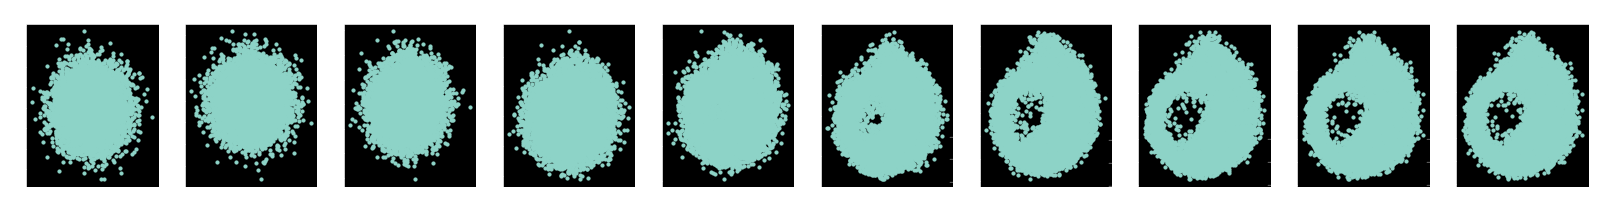

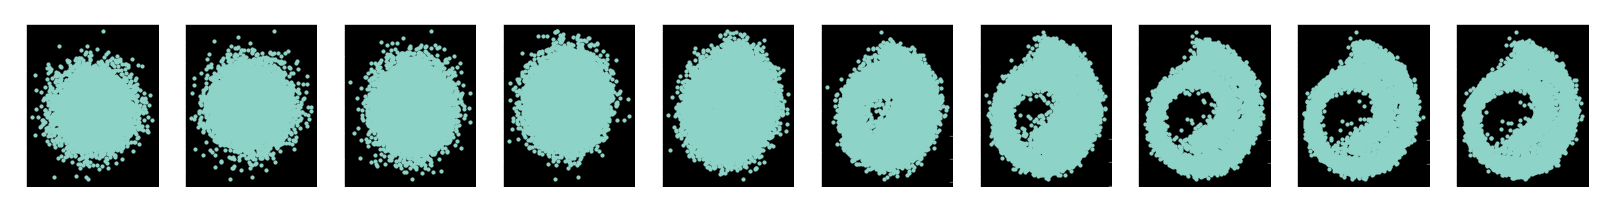

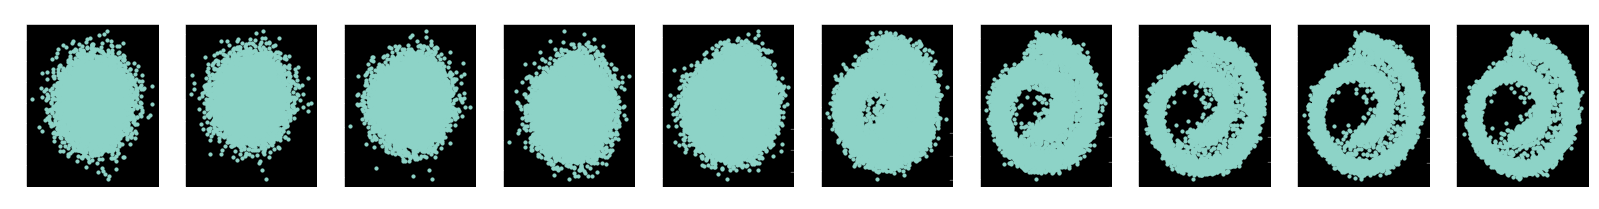

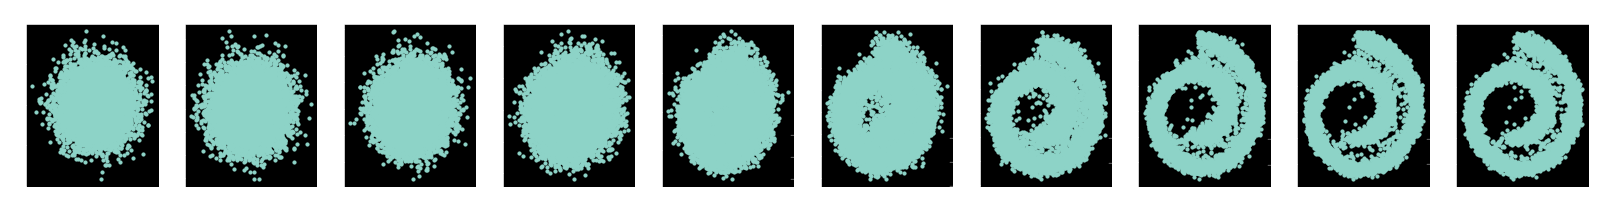

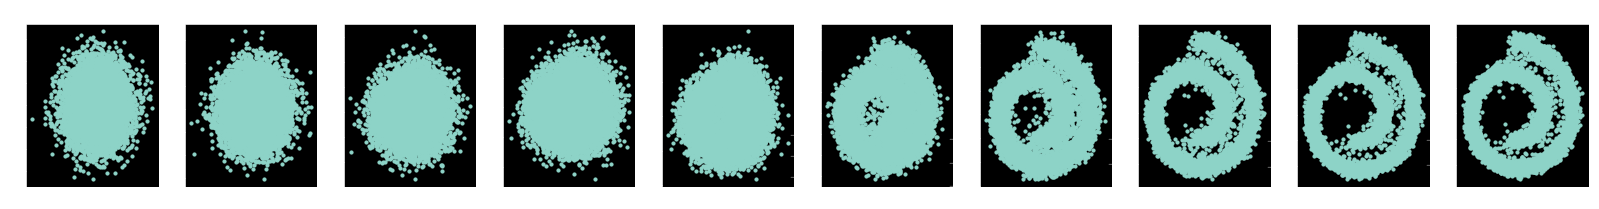

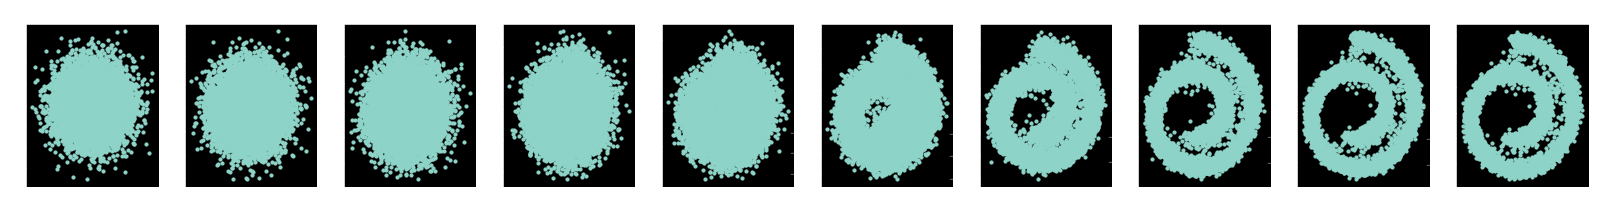

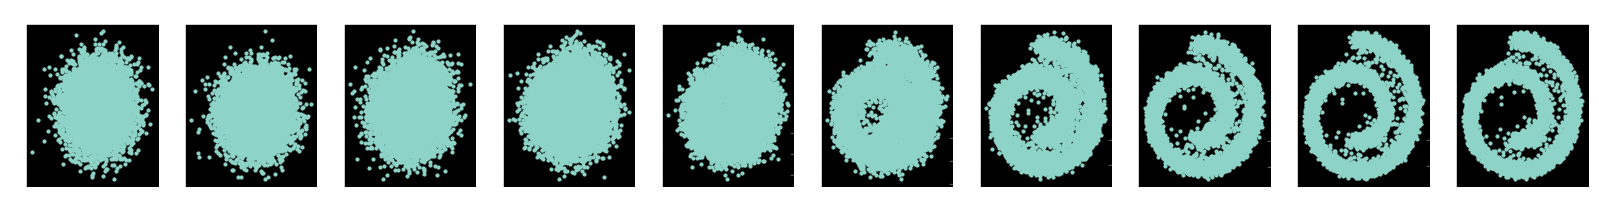

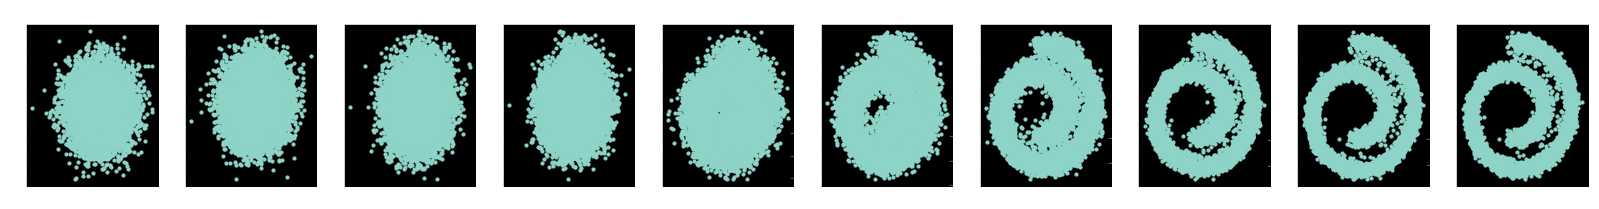

In [24]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## 参考

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)